In [4]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

import config as CFG
from models import CLIPModel, CLIPModel_ViT, CLIPModel_ViT_L, CLIPModel_CLIP, CLIPModel_resnet152, CLIPModel_resnet101
from dataset import CLIPDataset
import scanpy as sc
from torch.utils.data import DataLoader

import os
import numpy as np
import scanpy as sc

In [ ]:
#print the current scanpy version
print(sc.__version__)

In [2]:
def visualize_umap_clusters(expr_matrix, preprocess = True, normalize_and_log = True, batch_idx = None, n_neighbors=150, n_top_genes=1024, max_value=10, legend_loc='on data', show=False, save=False, save_name='umap_clusters.png'):
    #! scanpy input matrix has cells as rows and genes as columns, same as this function
    if preprocess:
        # # Filter out genes with expression in less than 50 spots (for a ~8000 spot dataset over 4 slices)
        # expressed = np.sum(expr_matrix>0, axis=0)
        # expr_matrix = expr_matrix[:,expressed>50]

        # Create AnnData object with batch index as an observation
        adata = sc.AnnData(X=expr_matrix, dtype=expr_matrix.dtype)
        if batch_idx is not None:
            adata.obs['batch_idx'] = batch_idx

        # Preprocess the data
        if normalize_and_log:
            sc.pp.normalize_total(adata)
            sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
        print("n_top_genes: ", adata.var['highly_variable'].sum())
        # sc.pp.scale(adata, max_value=max_value)
    else:
        adata = sc.AnnData(X=expr_matrix, dtype=expr_matrix.dtype)
        if batch_idx is not None:
            adata.obs['batch_idx'] = batch_idx

    # Run UMAP and clustering on the preprocessed data
    # sc.pp.scale(adata, max_value=max_value)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=preprocess)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=50)

    sc.tl.umap(adata)
    print("Running Leiden clustering")
    sc.tl.leiden(adata)
    print("n_clusters: ", adata.obs['leiden'].nunique())
    print("Plotting UMAP clusters")

    # Plot the UMAP embedding with cell clusters and batch index
    if batch_idx is None:
        fig, ax = plt.subplots(figsize=(6, 5))
        sc.pl.umap(adata, color='leiden', ax=ax, show=show, legend_loc=legend_loc)

        # Save the figure
        if save:
            fig.savefig(save_name, dpi=300, bbox_inches='tight')
        
        return adata

    else:
        fig, axs = plt.subplots(ncols=2, figsize=(10,5))

        # Plot the UMAP embedding with cell clusters
        sc.pl.umap(adata, color='leiden', ax=axs[0], show=False, legend_loc=legend_loc)

        # Plot the UMAP embedding with batch information
        sc.pl.umap(adata, color='batch_idx', ax=axs[1], show=False, legend_loc=legend_loc)


        # Save the figure
        if save:
            fig.savefig(save_name, dpi=300, bbox_inches='tight')

        return adata
    

def build_loaders_inference():
    print("Building loaders")
    #(3467, 2378) (3467, 2349) (3467, 2277) (3467, 2265)
    
    dataset1 = CLIPDataset(image_path = "~/GSE240429_data/images/GEX_C73_A1_Merged.tif",
                spatial_pos_path = "~/GSE240429_data/data/tissue_pos_matrices/tissue_positions_list_1.csv",
                reduced_mtx_path = "~/GSE240429_data/data/filtered_expression_matrices/1/harmony_matrix.npy",
                barcode_path = "~/GSE240429_data/data/filtered_expression_matrices/1/barcodes.tsv")
    dataset2 = CLIPDataset(image_path = "~/GSE240429_data/images/GEX_C73_B1_Merged.tif",
                spatial_pos_path = "~/GSE240429_data/data/tissue_pos_matrices/tissue_positions_list_2.csv",
                reduced_mtx_path = "~/GSE240429_data/data/filtered_expression_matrices/2/harmony_matrix.npy",
                barcode_path = "~/GSE240429_data/data/filtered_expression_matrices/2/barcodes.tsv")
    dataset3 = CLIPDataset(image_path = "~/GSE240429_data/images/GEX_C73_C1_Merged.tif",
                spatial_pos_path = "~/GSE240429_data/data/tissue_pos_matrices/tissue_positions_list_3.csv",
                reduced_mtx_path = "~/GSE240429_data/data/filtered_expression_matrices/3/harmony_matrix.npy",
                barcode_path = "~/GSE240429_data/data/filtered_expression_matrices/3/barcodes.tsv")
    dataset4 = CLIPDataset(image_path = "~/GSE240429_data/images/GEX_C73_D1_Merged.tif",
                spatial_pos_path = "~/GSE240429_data/data/tissue_pos_matrices/tissue_positions_list_4.csv",
                reduced_mtx_path = "~/GSE240429_data/data/filtered_expression_matrices/4/harmony_matrix.npy",
                barcode_path = "~/GSE240429_data/data/filtered_expression_matrices/4/barcodes.tsv")
    
    dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset3, dataset4])
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)

    print("Finished building loaders")
    return test_loader

def get_image_embeddings(model_path, model):
    test_loader = build_loaders_inference()
    # model = CLIPModel().cuda()

    state_dict = torch.load(model_path)
    new_state_dict = {}
    for key in state_dict.keys():
        new_key = key.replace('module.', '')  # remove the prefix 'module.'
        new_key = new_key.replace('well', 'spot') # for compatibility with prior naming
        new_state_dict[new_key] = state_dict[key]

    model.load_state_dict(new_state_dict)
    model.eval()

    print("Finished loading model")
    
    test_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            image_features = model.image_encoder(batch["image"].cuda())
            image_embeddings = model.image_projection(image_features)
            test_image_embeddings.append(image_embeddings)
    
    return torch.cat(test_image_embeddings)


def get_spot_embeddings(model_path, model):
    test_loader = build_loaders_inference()
    # model = CLIPModel().cuda()

    state_dict = torch.load(model_path)
    new_state_dict = {}
    for key in state_dict.keys():
        new_key = key.replace('module.', '')  # remove the prefix 'module.'
        new_key = new_key.replace('well', 'spot') # for compatibility with prior naming
        new_state_dict[new_key] = state_dict[key]

    model.load_state_dict(new_state_dict)
    model.eval()

    print("Finished loading model")

    spot_embeddings = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            # spot_features = model.spot_encoder(batch["reduced_expression"].cuda()) 
            # spot_embeddings = model.spot_projection(spot_features)
            spot_embeddings.append(model.spot_projection(batch["reduced_expression"].cuda()))
    return torch.cat(spot_embeddings)


#2265x256, 2277x256
def find_matches(spot_embeddings, query_embeddings, top_k=1):
    #find the closest matches 
    spot_embeddings = torch.tensor(spot_embeddings)
    query_embeddings = torch.tensor(query_embeddings)
    query_embeddings = F.normalize(query_embeddings, p=2, dim=-1)
    spot_embeddings = F.normalize(spot_embeddings, p=2, dim=-1)
    dot_similarity = query_embeddings @ spot_embeddings.T   #2277x2265
    print(dot_similarity.shape)
    _, indices = torch.topk(dot_similarity.squeeze(0), k=top_k)
    
    return indices.cpu().numpy()

In [ ]:
#outputs:
#data sizes: (3467, 2378) (3467, 2349) (3467, 2277) (3467, 2265)


datasize = [2378, 2349, 2277, 2265]
model_path = "clip/best.pt"
save_path = "clip/embeddings/"
model = CLIPModel().cuda()


img_embeddings_all = get_image_embeddings(model_path, model)
spot_embeddings_all = get_spot_embeddings(model_path, model)

img_embeddings_all = img_embeddings_all.cpu().numpy()
spot_embeddings_all = spot_embeddings_all.cpu().numpy()
print(img_embeddings_all.shape)
print(spot_embeddings_all.shape)

if not os.path.exists(save_path):
    os.makedirs(save_path)

for i in range(4):
    index_start = sum(datasize[:i])
    index_end = sum(datasize[:i+1])
    image_embeddings = img_embeddings_all[index_start:index_end]
    spot_embeddings = spot_embeddings_all[index_start:index_end]
    print(image_embeddings.shape)
    print(spot_embeddings.shape)
    np.save(save_path + "img_embeddings_" + str(i+1) + ".npy", image_embeddings.T)
    np.save(save_path + "spot_embeddings_" + str(i+1) + ".npy", spot_embeddings.T)


In [4]:

#infer spot embeddings and expression
spot_expression1 = np.load("filtered_expression_matrices/1/harmony_matrix.npy")
spot_expression2 = np.load("filtered_expression_matrices/2/harmony_matrix.npy")
spot_expression3 = np.load("filtered_expression_matrices/3/harmony_matrix.npy")
spot_expression4 = np.load("filtered_expression_matrices/4/harmony_matrix.npy")

save_path = "clip/embeddings/"
spot_embeddings1 = np.load(save_path + "spot_embeddings_1.npy")
spot_embeddings2 = np.load(save_path + "spot_embeddings_2.npy")
spot_embeddings3 = np.load(save_path + "spot_embeddings_3.npy")
spot_embeddings4 = np.load(save_path + "spot_embeddings_4.npy")
image_embeddings3 = np.load(save_path + "img_embeddings_3.npy")


#query
image_query = image_embeddings3
expression_gt = spot_expression3
spot_key = np.concatenate([spot_embeddings1, spot_embeddings2, spot_embeddings4], axis = 1)
expression_key = np.concatenate([spot_expression1, spot_expression2, spot_expression4], axis = 1)



In [ ]:
method = "average"
save_path = ""
if image_query.shape[1] != 256:
    image_query = image_query.T
    print("image query shape: ", image_query.shape)
if expression_gt.shape[0] != image_query.shape[0]:
    expression_gt = expression_gt.T
    print("expression_gt shape: ", expression_gt.shape)
if spot_key.shape[1] != 256:
    spot_key = spot_key.T
    print("spot_key shape: ", spot_key.shape)
if expression_key.shape[0] != spot_key.shape[0]:
    expression_key = expression_key.T
    print("expression_key shape: ", expression_key.shape)

if method == "simple":
    indices = find_matches(spot_key, image_query, top_k=1)
    matched_spot_embeddings_pred = spot_key[indices[:,0],:]
    print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
    matched_spot_expression_pred = expression_key[indices[:,0],:]
    print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

if method == "average":
    print("finding matches, using average of top 50 expressions")
    indices = find_matches(spot_key, image_query, top_k=50)
    matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
    matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
    for i in range(indices.shape[0]):
        matched_spot_embeddings_pred[i,:] = np.average(spot_key[indices[i,:],:], axis=0)
        matched_spot_expression_pred[i,:] = np.average(expression_key[indices[i,:],:], axis=0)
    
    print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
    print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

if method == "weighted_average":
    print("finding matches, using weighted average of top 50 expressions")
    indices = find_matches(spot_key, image_query, top_k=50)
    matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
    matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
    for i in range(indices.shape[0]):
        a = np.sum((spot_key[indices[i,0],:] - image_query[i,:])**2) #the smallest MSE
        weights = np.exp(-(np.sum((spot_key[indices[i,:],:] - image_query[i,:])**2, axis=1)-a+1))
        if i == 0:
            print("weights: ", weights)
        matched_spot_embeddings_pred[i,:] = np.average(spot_key[indices[i,:],:], axis=0, weights=weights)
        matched_spot_expression_pred[i,:] = np.average(expression_key[indices[i,:],:], axis=0, weights=weights)
    
    print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
    print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)



true = expression_gt
pred = matched_spot_expression_pred

print(pred.shape)
print(true.shape)
print(np.max(pred))
print(np.max(true))
print(np.min(pred))
print(np.min(true))

#genewise correlation
corr = np.zeros(pred.shape[0])
for i in range(pred.shape[0]):
    corr[i] = np.corrcoef(pred[i,:], true[i,:],)[0,1]
corr = corr[~np.isnan(corr)]
print("Mean correlation across cells: ", np.mean(corr))

corr = np.zeros(pred.shape[1])
for i in range(pred.shape[1]):
    corr[i] = np.corrcoef(pred[:,i], true[:,i],)[0,1]
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("mean correlation: ", np.mean(corr))
print("max correlation: ", np.max(corr))
print("number of genes with correlation > 0.3: ", np.sum(corr > 0.3))

if save_path != "":
    np.save(save_path + "matched_spot_embeddings_pred.npy", matched_spot_embeddings_pred.T)
    np.save(save_path + "matched_spot_expression_pred.npy", matched_spot_expression_pred.T)



In [3]:
#construct heatmap of the GGC matrix
expression_gt = np.load("data/filtered_expression_matrices/3/harmony_matrix.npy")
matched_spot_expression_pred_1 = np.load("clip/embeddings/matched_spot_expression_pred.npy")

# matched_spot_expression_pred_2 = sc.read_h5ad('data/from_collab/harmony_C1_HisToGene_adata_pred.h5ad')
# matched_spot_expression_pred_2 = matched_spot_expression_pred_2.X.T
# matched_spot_expression_pred_3 = sc.read_h5ad('data/from_collab/harmony_C1_STNet_adata_pred.h5ad')
# matched_spot_expression_pred_3 = matched_spot_expression_pred_3.X.T

print(expression_gt.shape)
print(matched_spot_expression_pred_1.shape)


(3467, 2277)
(3467, 2277)


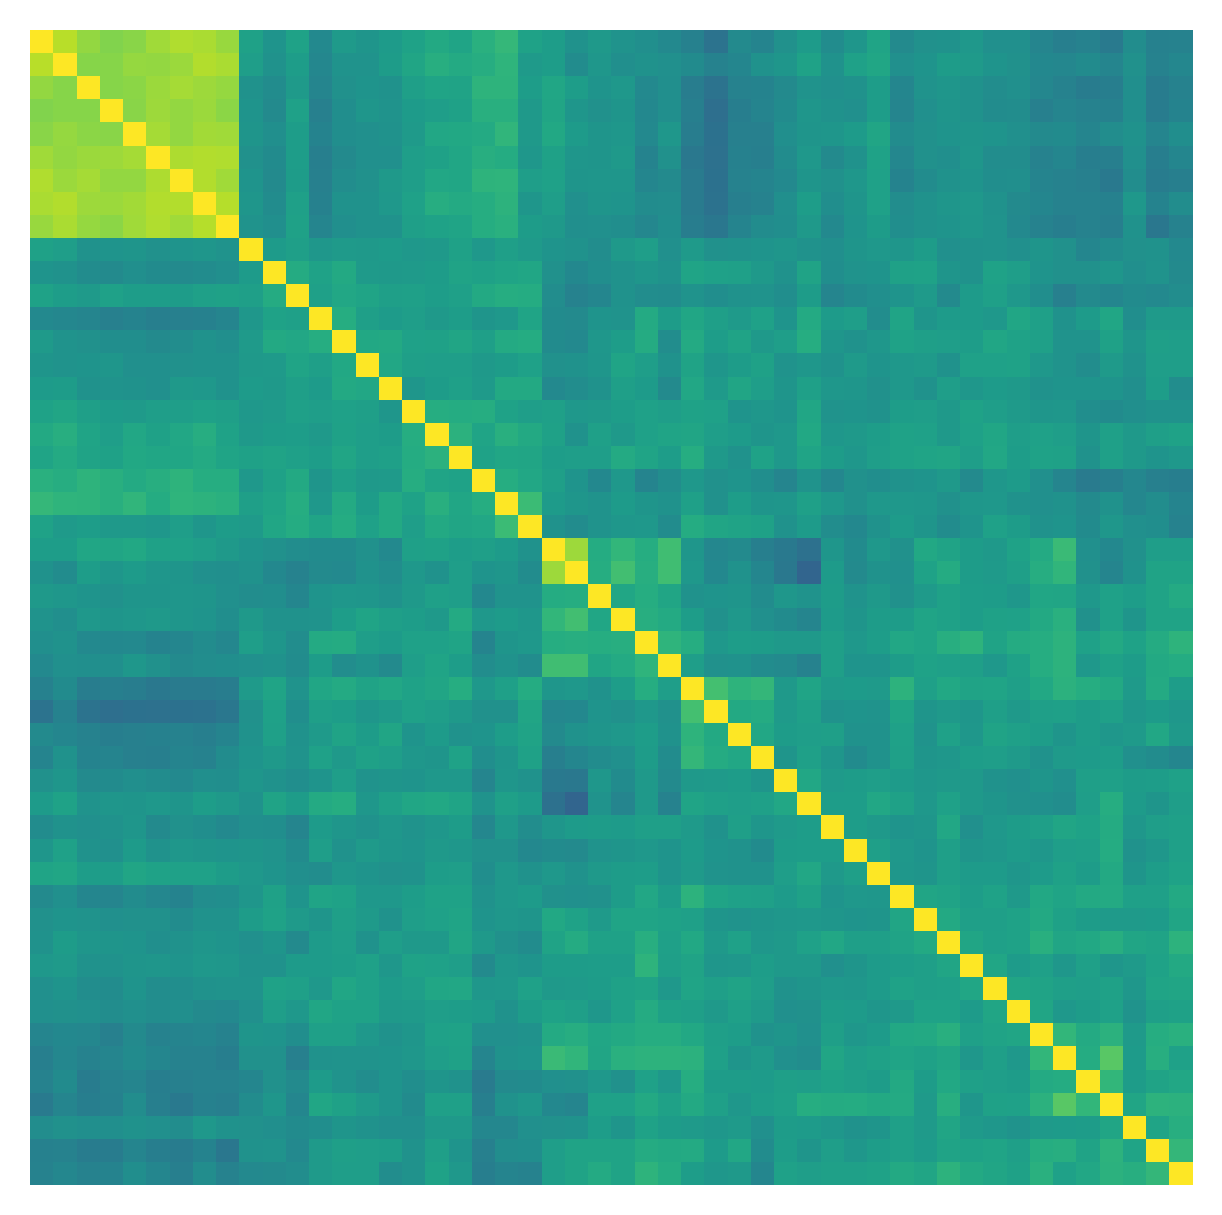

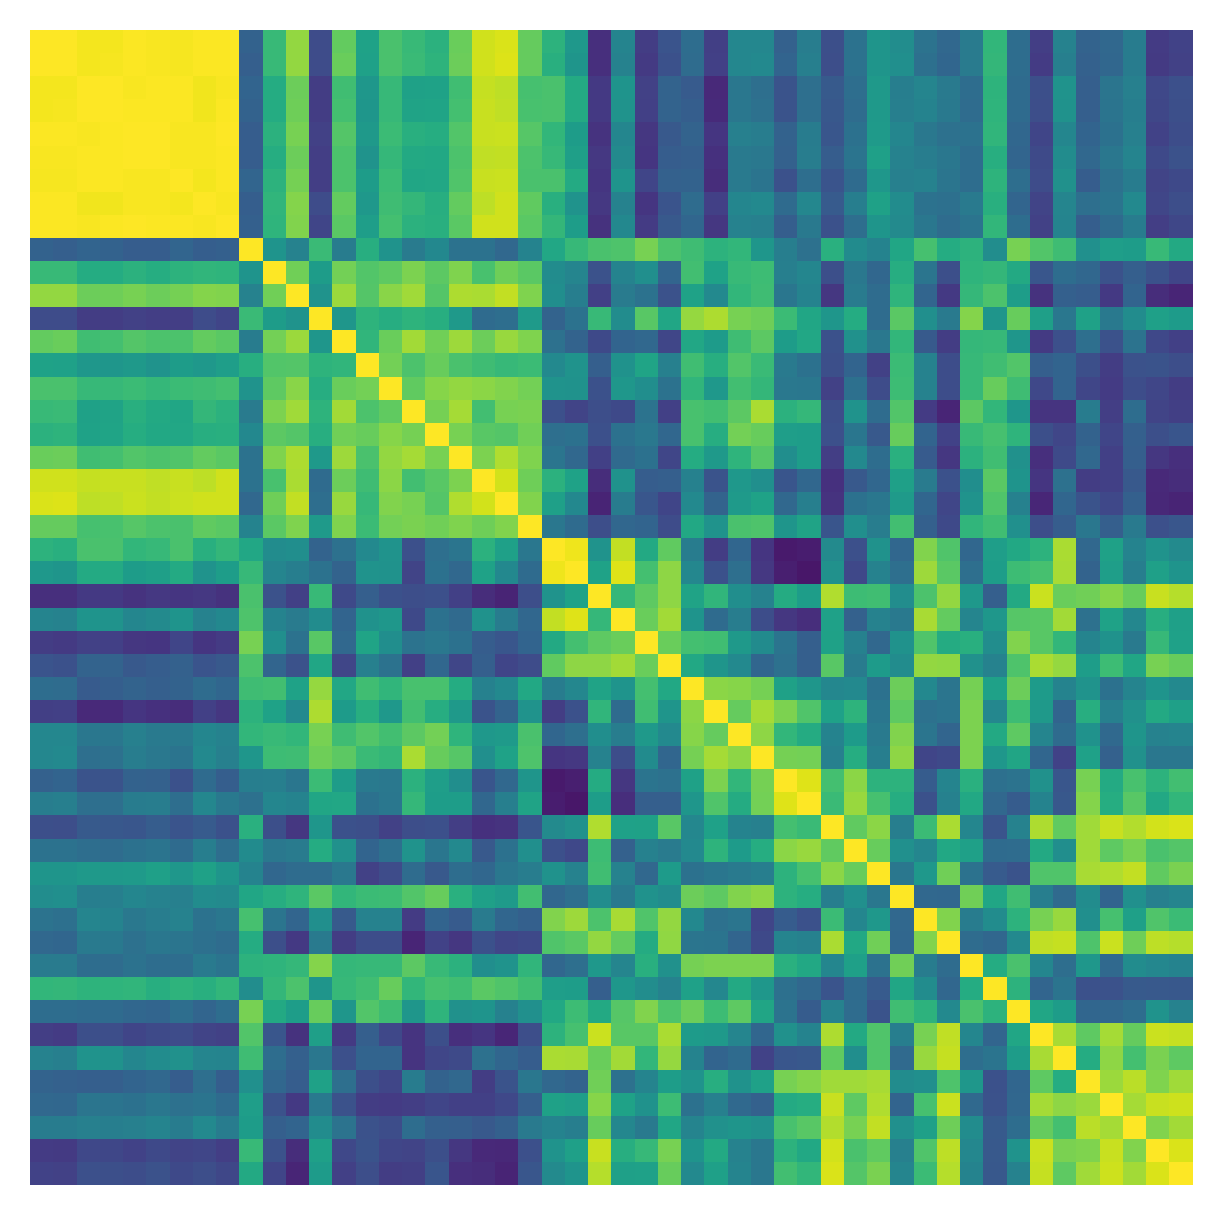

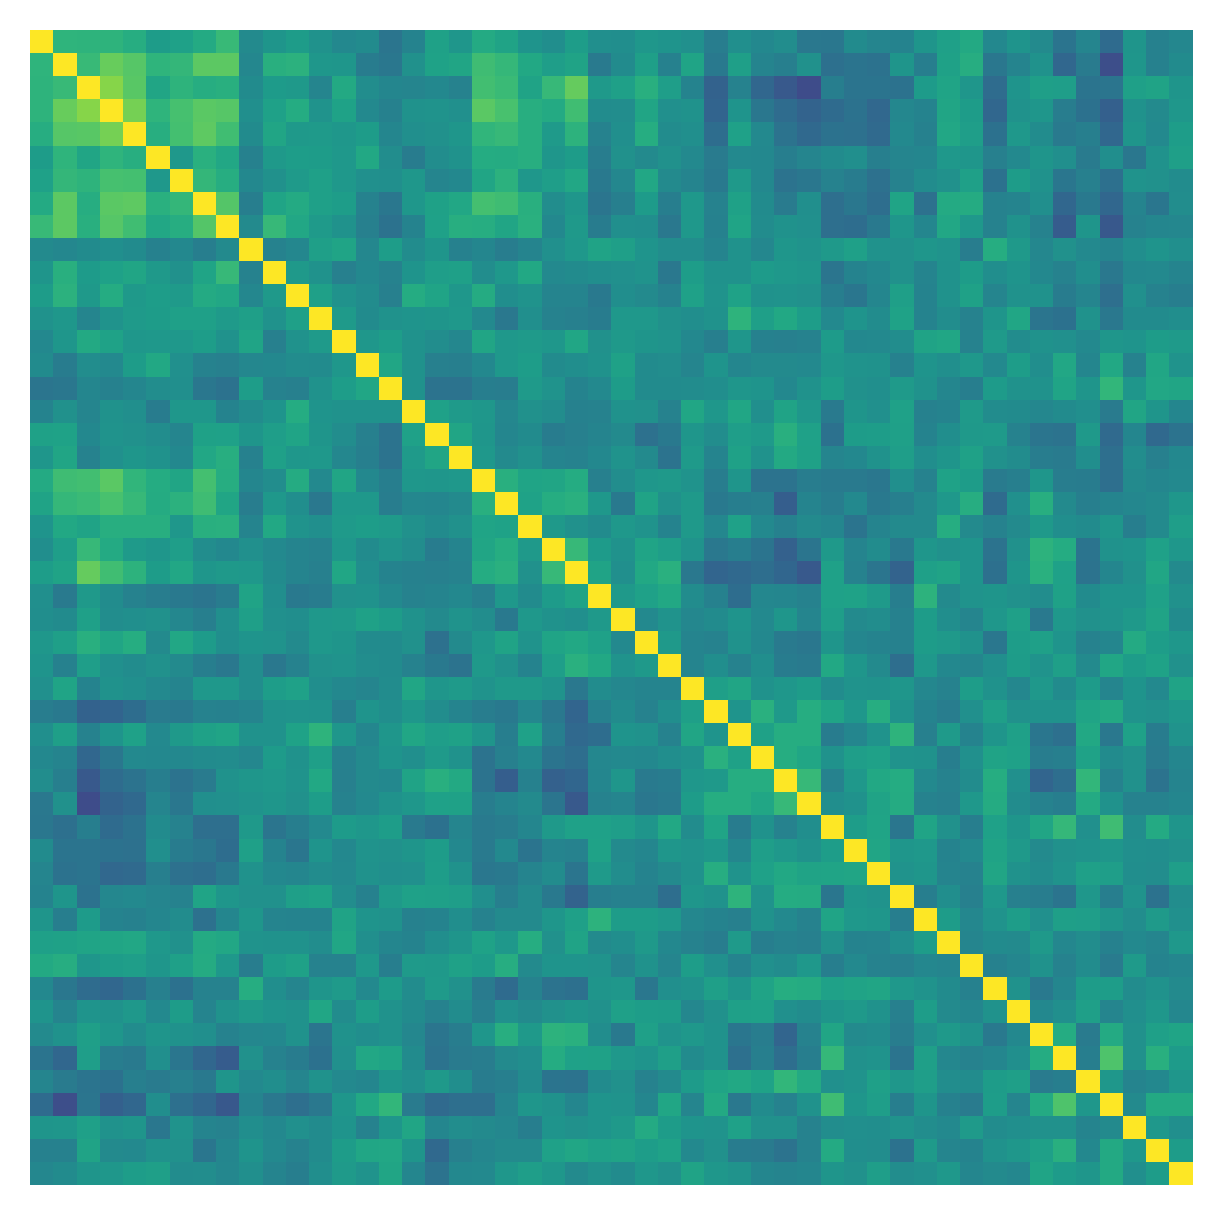

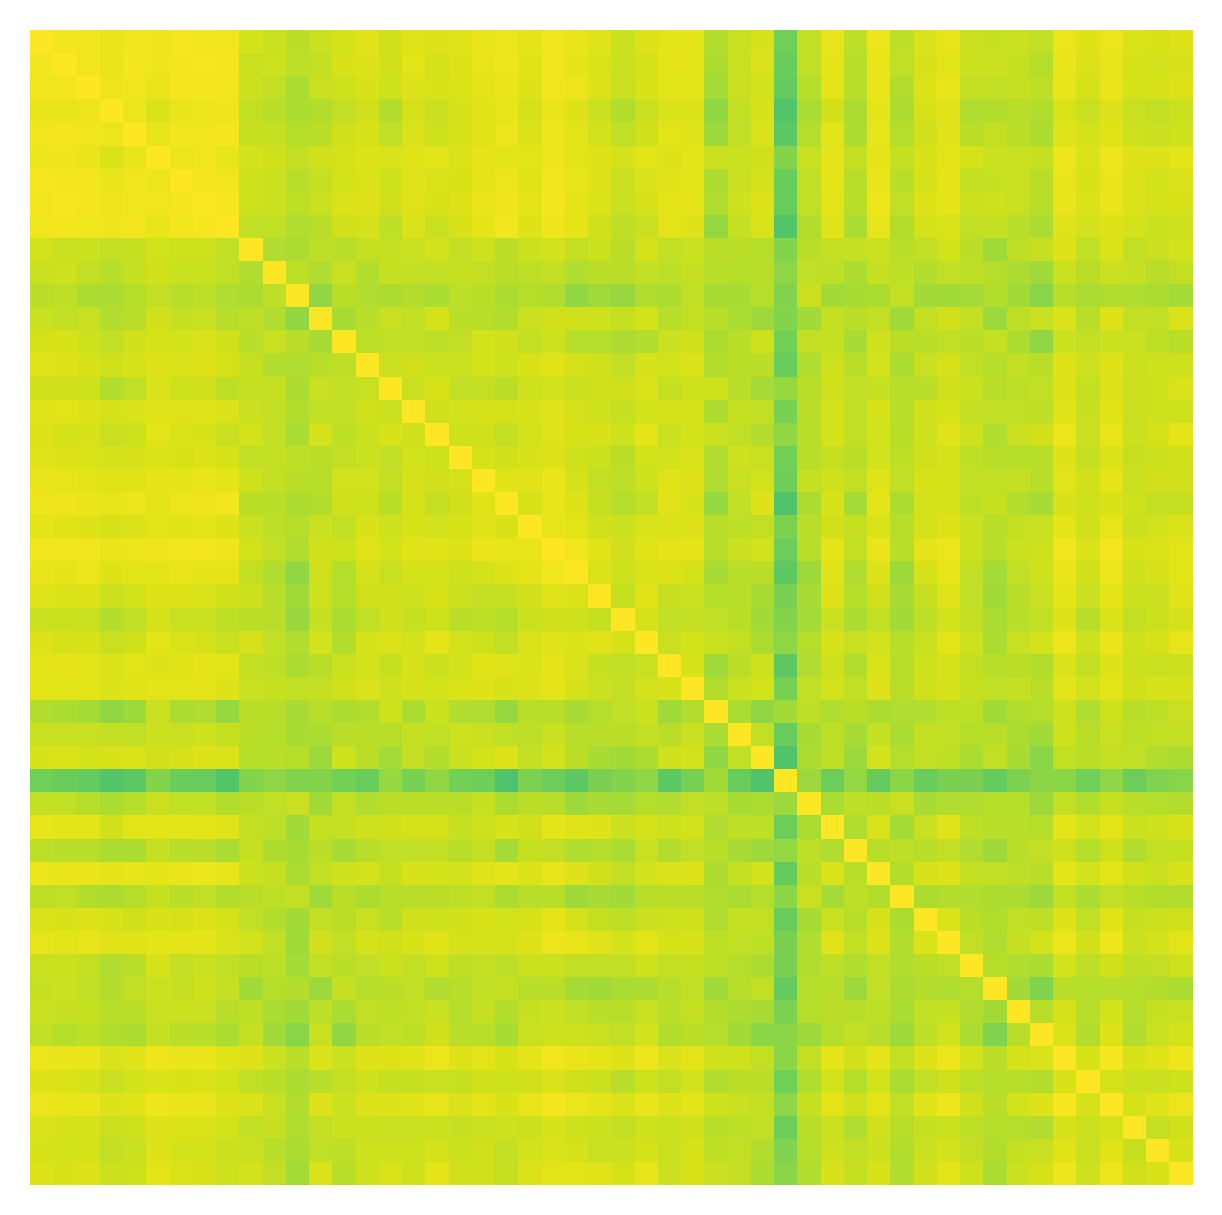

In [106]:
#plot heatmap of top 50 genes ranked by mean
def plot_heatmap(expression_gt, matched_spot_expression_pred, top_k=50):
    #take mean of expression
    mean = np.mean(expression_gt, axis=1)
    #take ind of top 100
    ind = np.argpartition(mean, -top_k)[-top_k:]

    # Compute the correlation matrix
    corr_matrix = np.corrcoef(expression_gt[ind,:])
    dendrogram = hierarchy.dendrogram(hierarchy.linkage(corr_matrix, method='ward'), no_plot=True)
    cluster_idx = dendrogram['leaves']

    corr_matrix = np.corrcoef(matched_spot_expression_pred[ind,:])
    corr_matrix = corr_matrix[cluster_idx, :]
    corr_matrix = corr_matrix[:, cluster_idx]

    # Reorder the correlation matrix and plot the heatmap
    plt.figure(dpi=300, figsize=(5,5))
    sns.heatmap(corr_matrix, cmap='viridis', xticklabels=False, yticklabels=False, cbar= False, vmin=-1, vmax=1)

plot_heatmap(expression_gt, expression_gt, top_k=50)
plot_heatmap(expression_gt, matched_spot_expression_pred_1, top_k=50)
# plot_heatmap(expression_gt, matched_spot_expression_pred_2, top_k=50)
# plot_heatmap(expression_gt, matched_spot_expression_pred_3, top_k=50)


